# 一 导入相关模块

In [1]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# 二 数据集情况
## 1数据集介绍 
>本项目使用Oxford-IIIT Pet数据集，是包括37个类别的宠物数据集，每个类别大约有200张图像。

>官网：https://www.robots.ox.ac.uk/~vgg/data/pets 。

>数据集统计如下：
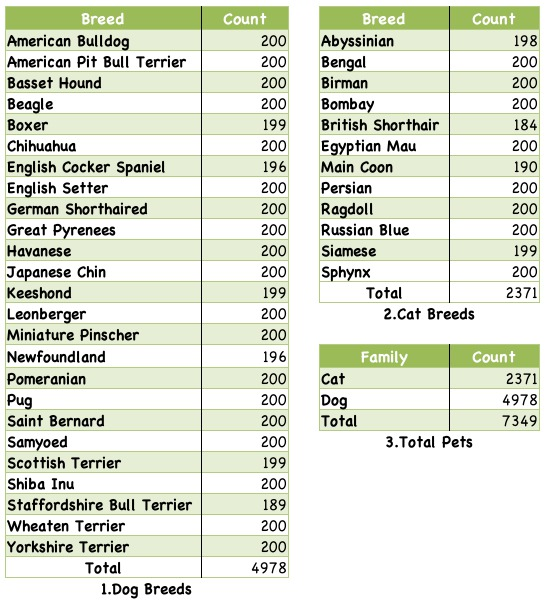

>数据集包含两个压缩文件：
>原图：https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
>分割图像：https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz




## 1.2查看图像总数量

In [2]:
IMAGE_SIZE =(160,160)
train_images_path = r'C:\Coding\CVtest\test2\data\images'
label_images_path = r'C:\Coding\CVtest\test2\data\annotations\trimaps'
image_count=len([os.path.join(train_images_path,image_name) for image_name in os.listdir(train_images_path)])
print("图像总数量：",image_count)

图像总数量： 7393


## 2 数据集处理

### 2.1 数据集标签制作

In [3]:
def sort_images(image_dir,image_type):
    """
    对文件夹内的图片按照文件名进行排序
    """
    files=[]
    for image_name in os.listdir(image_dir):
        if image_name.endswith(".{}".format(image_type)) \
        and not image_name.startswith("."):
            files.append(os.path.join(image_dir,image_name))
    return sorted(files)
def write_file(mode,images,labels):
    with open('./{}.txt'.format(mode),'w') as f:
        for i in range(len(images)):
            f.write('{}\t{}\n'.format(images[i],labels[i]))
"""
由于所有文件都是散落在文件夹中，在训练时我们需要使用的是数据集和标签对应的数据关系，
所以我们第一步是对原始的数据集进行整理，得到数据集和标签两个数组，分别一一对应。
这样可以在使用的时候能够很方便的找到原始数据和标签的对应关系，否则对于原有的文件夹图片数据无法直接应用。
在这里是用了一个非常简单的方法，按照文件名称进行排序。
因为刚好数据和标签的文件名是按照这个逻辑制作的，名字都一样，只有扩展名不一样。
"""
images=sort_images(train_images_path,'jpg')
labels=sort_images(label_images_path,'png')
eval_num=int(image_count*0.15)

write_file('train',images[:-eval_num],labels[:-eval_num])
write_file('eval',images[-eval_num:],labels[-eval_num:])
write_file('predict',images[-eval_num:],labels[-eval_num:])

### 2.2抽样展示

1 3


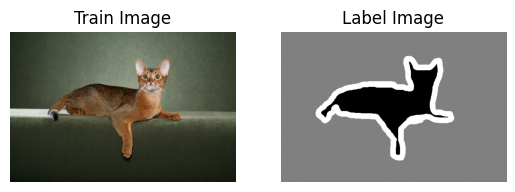

1 3


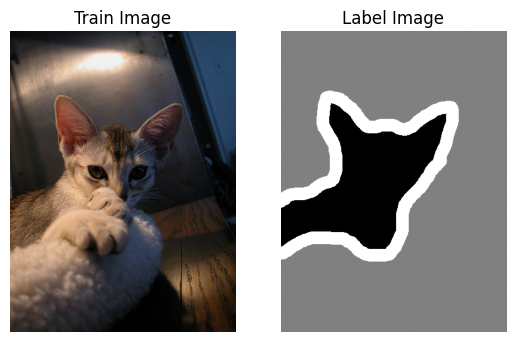

1 3


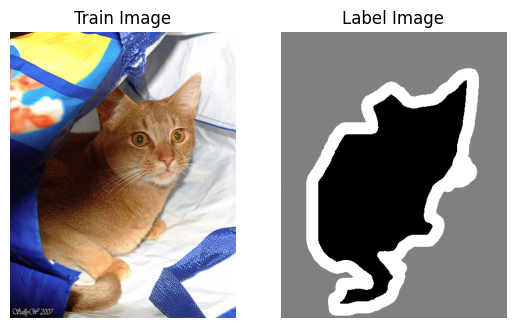

In [4]:
with open("./train.txt",'r') as f:
    i=0;
    for line in f.readlines():
        image_path,label_path=line.strip().split('\t')
        image=np.array(PILImage.open(image_path))
        label=np.array(PILImage.open(label_path))
        if i>2:
            break
        #进行图片展示
        print(label.min(),label.max())
        plt.figure()
        plt.subplot(1,2,1)
        plt.title('Train Image')    
        plt.imshow(image.astype('uint8'))
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title('Label Image')
        plt.imshow(label.astype('uint8'),cmap='gray')
        plt.axis('off')

        plt.show()
        i+=1


### 2.3 数据集类定义

In [5]:
import random
from torch.utils.data import Dataset
import torchvision.transforms as T

class ImageDataset(Dataset):
    def __init__(self,mode='train',image_size=(160,160)):
        super().__init__()
        self.image_size=image_size
        self.mode=mode.lower()

        assert self.mode in ['train','eval','predict'],\
            "mode should be 'train' or 'eval' or 'predict',but got {}".format(self.mode)

        self.train_images=[]
        self.label_images=[]
        with open('./{}.txt'.format(self.mode),'r') as f:
            for line in f.readlines():
                image_path,label_path=line.strip().split('\t')
                self.train_images.append(image_path)
                self.label_images.append(label_path)
                
    def _load_image(self,path,color_mode='rgb',transforms=[]):
        """
        统一的图像处理接口封装，用于规整图像大小和通道
        """
        with open(path,'rb') as f:
            image=PILImage.open(io.BytesIO(f.read()))
            if color_mode=='gray':
                if image.mode not in ('L','I;16','I'):
                    image=image.convert('L')
            elif color_mode=='rgb':
                if image.mode!='RGB':
                    image=image.convert('RGB')
            elif color_mode=='rgba':
                if image.mode!='RGBA':
                    image=image.convert('RGBA')
            else:
                raise ValueError("color_mode should be 'gray' or 'rgba'")
            return T.Compose([
                T.Resize(self.image_size)
                ]+transforms)(image)
    def __getitem__(self,index):
        train_image=self._load_image(self.train_images[index],
                                     transforms=[
                                         T.ToTensor(),
                                         T.Normalize(0.5,0.5)
                                     ])
        label_image=self._load_image(self.label_images[index],
                                     color_mode='gray',
                                     transforms=[
                                         T.Grayscale()
                                     ])
        train_image=np.array(train_image,dtype='float32')
        label_image=np.array(label_image,dtype='int64')
        return train_image,label_image
    def __len__(self):
        return len(self.train_images)


# 三 模型定义
模型结构
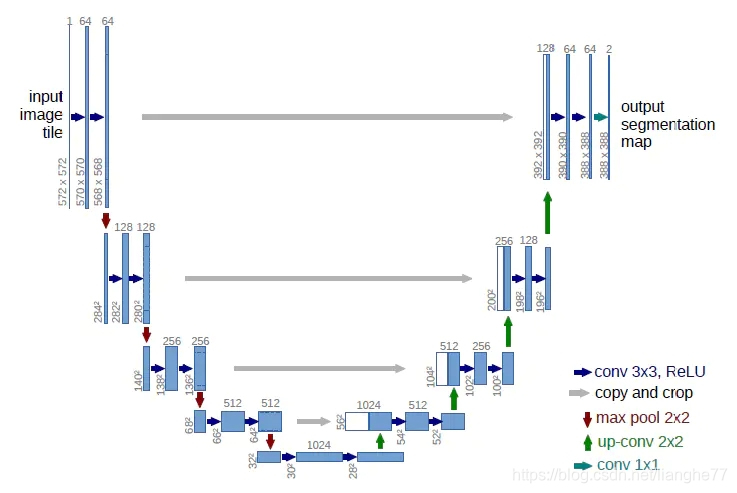

## 3.1 下采样相关

In [6]:
class DoubleConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(DoubleConv,self).__init__()
        self.double_conv=nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.double_conv(x)

In [7]:
class Down(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Down,self).__init__()
        self.maxpool_conv=nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2,padding=0),
            DoubleConv(in_channels,out_channels)
        )
    def forward(self,x):
        return self.maxpool_conv(x)

### 3.2 上采样相关

In [8]:
class Up(nn.Module):
    def __init__(self,in_channels,out_channels,bilinear=True):
        super(Up,self).__init__()

        if bilinear:
            self.up=nn.Upsample(scale_factor=2,mode='bilinear',align_corners=True)
        else:
            self.up=nn.ConvTranspose2d(in_channels//2,in_channels//2,kernel_size=2,stride=2)
        self.conv=DoubleConv(in_channels,out_channels)
    def forward(self,x1,x2):
        x1=self.up(x1)
        diffY=x2.size()[2]-x1.size()[2]
        diffX=x2.size()[3]-x1.size()[3]
        x1=F.pad(x1,[diffX//2,diffX-diffX//2,diffY//2,diffY-diffY//2])
        x=torch.cat([x2,x1],dim=1)
        return self.conv(x)

### 3.3模型整体结构

In [9]:
class U_Net(nn.Module):
    def __init__(self,num_classes,bilinear=True):
        super(U_Net,self).__init__()
        self.num_classes=num_classes
        self.bilinear=bilinear
        self.inc=DoubleConv(3,64)
        self.down1=Down(64,128)
        self.down2=Down(128,256)
        self.down3=Down(256,512)
        self.down4=Down(512,512)
        self.up1=Up(1024,256,bilinear)
        self.up2=Up(512,128,bilinear)
        self.up3=Up(256,64,bilinear)
        self.up4=Up(128,64,bilinear)
        self.outc=nn.Conv2d(64,num_classes,kernel_size=1)
    def forward(self,x):
        x1=self.inc(x)
        x2=self.down1(x1)
        x3=self.down2(x2)
        x4=self.down3(x3)
        x5=self.down4(x4)
        x=self.up1(x5,x4)
        x=self.up2(x,x3)
        x=self.up3(x,x2)
        x=self.up4(x,x1)
        y=self.outc(x)

        return y

### 3.4 模型可视化

In [10]:
num_classes=3
netwrok=U_Net(num_classes=num_classes).to(device)
print(netwrok)

U_Net(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momen

# 四 模型训练

In [11]:
from tqdm import tqdm
import time
def train_model(model,train_loader,eval_loader,criterion,optimizer,num_epochs=20,device='cpu'):
    since=time.time()
    train_loss_history=[]
    eval_loss_history=[]
    eval_acc_history=[]
    best_model_wts=model.state_dict()
    best_acc=0.0

    model=model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        model.train()
        running_loss=0.0

        with tqdm(total=len(train_loader),desc='Trainging') as pbar:
            for inputs,labels in train_loader:
               
                inputs=inputs.to(device)
                labels=labels.to(device)
                # print(inputs[0].max(),inputs[0].min())
                labels=labels-1 #标签的灰度只有 1 2 3 三种，所以减去1，变为0 1 2（交叉熵损失函数要求类别从0开始）
                # print(labels[0].max(),labels[0].min())
                optimizer.zero_grad()

                outputs=model(inputs)
                # print(outputs[0].max(),outputs[0].min())
                loss=criterion(outputs,labels)

                loss.backward()
                optimizer.step()

                running_loss+=loss.item()*inputs.size(0)
                pbar.update(1)
                pbar.set_postfix_str('Loss: {:.4f}'.format(loss.item()))
        epoch_loss=running_loss/len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        print(f'Train_Loss: {epoch_loss:.4f}')
        model.eval()
        eval_running_loss=0.0
        eval_running_corrects=0
        with torch.no_grad(),tqdm(total=len(eval_loader),desc='Evaluating') as pbar:
            for inputs,labels in eval_loader:
                inputs=inputs.to(device)
                labels=labels.to(device)
            
                labels = labels - 1
                # print(labels[0].max(),labels[0].min())
                outputs=model(inputs)
                # print(outputs[0].max(),outputs[0].min())
                loss=criterion(outputs,labels)

                eval_running_loss+=loss.item()*inputs.size(0)

                preds=torch.argmax(outputs,dim=1)
                eval_running_corrects+=torch.sum(preds==labels)

                pbar.update(1)
                pbar.set_postfix_str('Loss: {:.4f}'.format(loss.item()))
        eval_epoch_loss=eval_running_loss/len(eval_loader.dataset)
        eval_epoch_acc=eval_running_corrects.double()/(len(eval_loader.dataset)*labels.shape[-2]*labels.shape[-1])
        
        eval_loss_history.append(eval_epoch_loss)
        eval_acc_history.append(eval_epoch_acc.cpu().numpy())

        print(f'Train Loss: {epoch_loss:.4f} Val Loss: {eval_epoch_loss:.4f} Acc: {eval_epoch_acc:.4f}')

        if eval_epoch_acc>best_acc:
            best_acc=eval_epoch_acc
            best_model_wts=model.state_dict()
            torch.save(model.state_dict(),'best_model.pth')
            print(f"保存最佳模型，验证准确率: {best_acc:.4f}")
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model,train_loss_history,eval_loss_history,eval_acc_history
    

In [12]:
def visualize_model(train_loss,eval_loss,eval_acc):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(eval_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(eval_acc, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize model, dataloaders, criterion and optimizer
model = U_Net(num_classes=3)
batch_size = 32
num_epochs = 20
train_dataset = ImageDataset(mode='train', image_size=IMAGE_SIZE)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageDataset(mode='eval', image_size=IMAGE_SIZE)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001,alpha=0.9,eps=1e-7,momentum=0,centered=False)
# Train the model
model, train_loss, eval_loss, eval_acc = train_model(
    model=model,
    train_loader=train_loader,
    eval_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device
)

# Visualize results
visualize_model(train_loss, eval_loss,eval_acc)


Epoch 0/9
----------


Trainging:   4%|▍         | 8/197 [00:49<19:18,  6.13s/it, Loss: 0.9420]


KeyboardInterrupt: 

# 四 模型评估

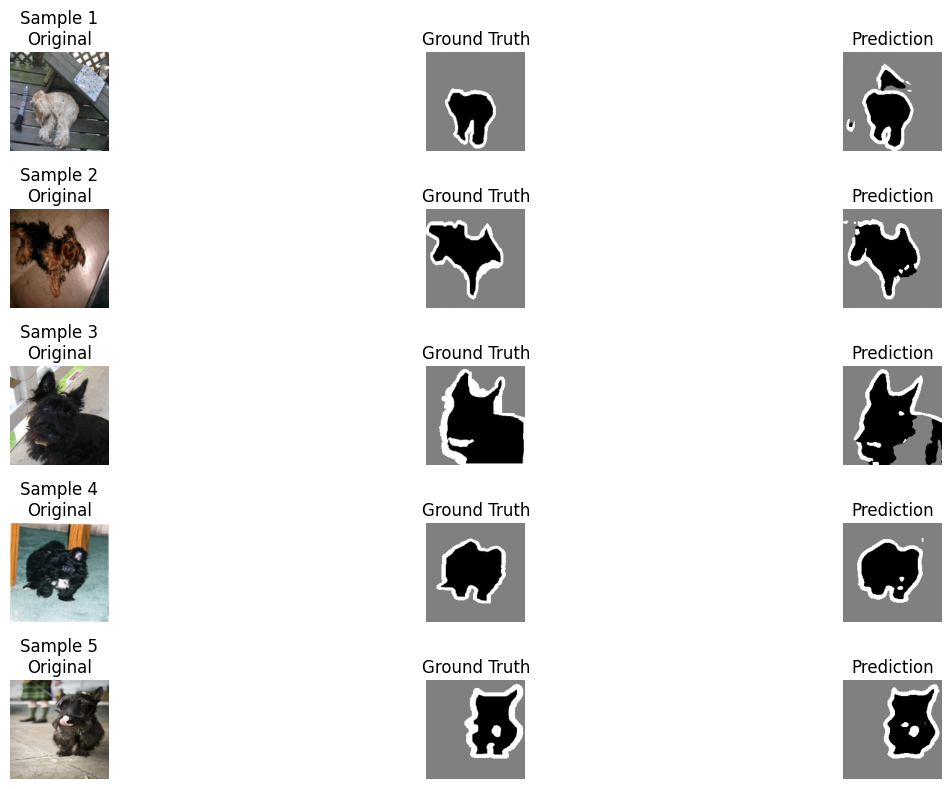

In [246]:
def predict_and_visualize(model, predict_loader, device, num_samples=5):
    model.eval()
    samples = []
    
    # 获取前5个样本
    with torch.no_grad():
        for i, (images, labels) in enumerate(predict_loader):
            if i >= num_samples:
                break
        
            # 预测
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            # 反归一化原图
            image_np = images.cpu().numpy()[0]
            image_np = ((image_np * 0.5 + 0.5)*255).transpose(1, 2, 0)
            image_np=image_np.astype(np.uint8)
            
            # 处理标签和预测结果
            label_np = labels.numpy()[0].squeeze().astype(np.uint8)
            pred_np = preds[0].astype(np.uint8)
            pred_np=pred_np+1
            samples.append((image_np, label_np, pred_np))
    
    # 可视化对比
    plt.figure(figsize=(15, 8))
    for idx in range(num_samples):
        image, label, pred = samples[idx]
        
        # 显示原图
        plt.subplot(num_samples, 3, idx*3 + 1)
        plt.imshow(image)
        plt.title(f'Sample {idx+1}\nOriginal')
        plt.axis('off')
        
        # 显示标签
        plt.subplot(num_samples, 3, idx*3 + 2)
        plt.imshow(label,cmap='gray')  # 使用jet颜色映射更好区分类别
        plt.title('Ground Truth')
        plt.axis('off')
        
        # 显示预测
        plt.subplot(num_samples, 3, idx*3 + 3)
        plt.imshow(pred,cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 加载最佳模型
model = U_Net(num_classes=3)
model.load_state_dict(torch.load(r'C:\Coding\CVtest\test2\best_model_20.pth',weights_only=True))
model.to(device)

# 创建预测数据集
predict_dataset = ImageDataset(mode='predict', image_size=IMAGE_SIZE)
predict_loader = torch.utils.data.DataLoader(
    predict_dataset, 
    batch_size=1, 
    shuffle=True  
)

# 执行预测并可视化
predict_and_visualize(model, predict_loader, device, num_samples=5)
